__________
## Advisory!
** This is the stripped down `dw-nominate` notebook. <br>
If you're new to Python or want thorough documentation, please view the <a href='https://nbviewer.jupyter.org/github/yinleon/congress/blob/master/dw-nominate-detail.ipynb'>`dw-nominate-detail`</a> notebook.**
____________

# DW-Nominate Exploration

The Nominate scoring scale was first developed by Keith T. Poole and Howard Rosenthal in the late 1980's.<br>
Since then, it has undergone several iterations, with the DW-series being the latest.<br>
Scores are derived from roll call votes, and contain 2 dimensions:<br>
1. Allowing us to place Senators, House members, and their political orgs on the liberal-convervative [-1, 1] spectrum (1st dimension). <br>
2. Nominate also quantifies the opposition/support of civil rights for underrepresented minorities (2nd dimension).

Read more about these metrics on the <a href='http://www.voteview.com/dwnomin.htm'>Voteview website</a>.

The following notebook is going to build off a visualization made by the <a href='http://www.pewresearch.org/fact-tank/2014/06/12/polarized-politics-in-congress-began-in-the-1970s-and-has-been-getting-worse-ever-since/'>Pew Research Institute</a>, by making a gif of changes of house ideology accross congresses.

Here's the finished product:

In [150]:
IPython.display.HTML('<iframe src="//giphy.com/embed/l3q2sdwiyf3bWCLwQ" '
                     'width="480" height="407" frameBorder="0" '
                     'class="giphy-embed" allowFullScreen></iframe>')

We're going to
1. Read a fixed-width text file from an anonymous ftp hosted on the web.
2. Use Pandas dataframes to filter, replace, and aggregate data.
3. Plot data using Panda's Matplotlib extension.
4. Generate a GIF out of static png files.

In [1]:
%matplotlib inline
import os
import glob

import us
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import imageio

where the raw files are hosted:

In [2]:
senate_dl = 'ftp://k7moa.com/junkord/SL01113D21_BSSE.dat'
house_dl = 'ftp://k7moa.com/junkord/HL01113D21_BSSE.DAT'

We can store these links in a list of <a href='todo'>tuples</a>, later we'll iterate through `args` to download the correct files.

In [3]:
args = [('senate', senate_dl),
        ('house', house_dl)]

In [4]:
for arg in args:
    print(arg[1])

ftp://k7moa.com/junkord/SL01113D21_BSSE.dat
ftp://k7moa.com/junkord/HL01113D21_BSSE.DAT


columns copied and pasted from voteview docs.

In [5]:
cols = '''Congress Number
ICPSR ID Number
State Code
Congressional District Number
State Name
Party Code
Name
1st Dimension Coordinate
2nd Dimension Coordinate
1st Dimension Bootstrapped Standard Error  
2nd Dimension Bootstrapped Standard Error
Correlation Between 1st and 2nd Dimension
Log-Likelihood
Number of Votes
Number of Classification Errors
Geometric Mean Probability'''.split('\n')

In [91]:
"We split the columns by a newline character (\n), to get {} columns.".format(len(cols))

'We split the columns by a newline character (\n), to get 16 columns.'

In [7]:
col_widths = [(0,4), (4,10), (10,13), (13,15), 
              (15,23), (23,28), (28,40), (40,50), 
              (50,60), (60,70), (70,80), (80,90),
              (90,102), (102,107), (107, 112)]

In [77]:
# This dict is for compat. with Propublica Congress API.
col_mapping = {'Name' : 'last_name', 
               'Congress Number': 'Congress'}

# dict comprehension to convert state names to abbreviations.
state_dict = {state.name.upper()[:7] : state.abbr for state in us.states.STATES}

In [70]:
df = pd.read_fwf(house_dl, names=cols, colspecs=col_widths)

In [87]:
df.head(3)

,Congress Number,ICPSR ID Number,State Code,Congressional District Number,State Name,Party Code,Name,1st Dimension Coordinate,2nd Dimension Coordinate,1st Dimension Bootstrapped Standard Error,2nd Dimension Bootstrapped Standard Error,Correlation Between 1st and 2nd Dimension,Log-Likelihood,Number of Votes,Number of Classification Errors,Geometric Mean Probability
0,1,9062,1,98,CONNECT,5000,STURGES,0.648,0.330,0.1129,0.1204,-0.1329,-26.87624,80,12,NaN
1,1,9706,1,98,CONNECT,5000,WADSWORTH,0.759,0.136,0.0751,0.1067,-0.2138,-18.20466,86,4,NaN
2,1,8457,1,98,CONNECT,5000,SHERMAN,0.715,0.203,0.0759,0.2234,-0.2127,-39.45672,107,18,NaN


Let's read both files into one dataframe.

In [14]:
df_congress = pd.DataFrame()

for chamber in args:
    df = pd.read_fwf(chamber[1], names=cols, colspecs=col_widths)
    
    # replace column names from col_mapping dict
    df.columns = [col_mapping.get(col, col) for col in df.columns]
    
    # create column for senate or house
    df['chamber'] = chamber[0]
    
    # convert state names to state id.
    df['state'] = df['State Name'].replace(state_dict)
    
    df_congress = df_congress.append(df, ignore_index=True)

In [15]:
df_congress.chamber.unique()

array(['senate', 'house'], dtype=object)

let's set some variables for the next graph.

In [54]:
first_congress_yr = 1789
colors = ['b', 'r']
annotation = ('Ideology score from 1st Dimensional Coordinate of DW-Nominate\n'
              'Source: voteview.com/dwnomin.htm\nAuthor: @leonyin')
col_name = 'More Liberal' + (57 * ' ') + 'More Conservative'

house_plot = {
    'ylim' : [0, 80],
    'y_maj' : 20,
    'y_min' : 10,
    'ylabel': '# House Reps'
}

senate_plot ={
    'ylim' : [0, 24],
    'y_maj' : 8,
    'y_min' : 4,
    'ylabel' : '# Senators'
}

In [36]:
def get_nominal(x):
    '''
    Returns a nominal for each congress number
    '''
    if x % 10 == 1 and x < 110:
        return 'st'
    elif x % 10 == 2 and x < 110:
        return 'nd'
    elif x % 10 == 3 and x < 110:
        return 'rd'
    else:
        return 'th'

def rep_dem_indie(row):
    '''
    Maps Democrat, Republican, or Other for a given Pandas row.
    '''
    if row['Party Code'] == 100:
        return 'D'
    elif row['Party Code'] == 200:
        return 'R'
    else:
        return None

In [139]:
def plot_polarity(congress, chamber='senate', how='area', 
                  col='1st Dimension Coordinate'):
    '''
    Plot the liberal-conservative polarity for a congress
    for either house of reps or senate.
    
    The default metric plotted is the 1st dim coordinate.
    '''
    if chamber == 'house':
        plot_vars = house_plot
    else:
        plot_vars = senate_plot
    
    # Set variables for title
    congress_year = first_congress_yr + (2 * congress) - 2
    congress_nominal = str(congress) + get_nominal(congress)
    
    # create supertitle and subtitle.
    sup_title = '{} Ideology'.format(chamber.title())
    title = '{} Congress {}-{}'.format(congress_nominal,
                                       congress_year, 
                                       congress_year + 1)
   
    # filter the df to the correct conress and chamber.
    df_c = df_congress[(df_congress['Congress'] == congress) & 
                       (df_congress['chamber'] == chamber)]
   
    # fix up the party names.
    df_c['Party'] = df_c.apply(rep_dem_indie, axis=1)
    
    # round ideology dimension.
    df_c[col_name] = df_c[col].round(1)
    
    # this groupby creates a multi-index,
    # to remove one index, we use the unstack() function,
    # reverting Party back into a column
    df2 = df_c.groupby(['Party', col_name])[col_name].count() \
              .unstack('Party').fillna(0)
    
    # below is all matplotlib functions.
    fig = plt.figure()
    fig.suptitle(sup_title, fontsize=17)
    ax = fig.add_subplot(111)
    
    # plot the one line per party
    df2[['D','R']].plot(kind=how, stacked=False, 
                        color=colors, alpha=.46,
                        xlim=[-1,1], ylim=plot_vars['ylim'],
                        ax=ax, title=title)
    # add y label
    ax.set_ylabel(plot_vars['ylabel'])
    
    # vertical line at x = 0
    plt.axvline(0, color='k', linestyle='dotted')
    
    # plot legend
    plt.legend(loc='upper right', frameon=False)
    
    # tailor x and y axis ticks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(.1))
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(plot_vars['y_maj']))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(plot_vars['y_min']))
    
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # write annotations
    plt.annotate(annotation, (0,0), (0, -32), xycoords='axes fraction', 
                 textcoords='offset points', va='top')
    plt.subplots_adjust(top=0.86)
    
    # save the figure in as a png
    plt.savefig('figs/{}/{}.png'.format(chamber, congress), 
                bbox_inches='tight', dpi=100)

/Users/leonyin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leonyin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


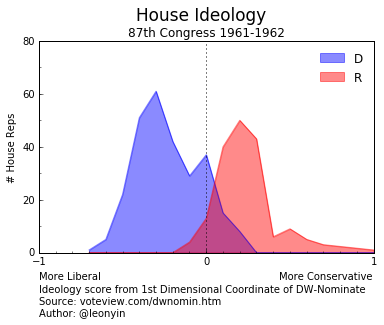

In [140]:
plot_polarity(87, chamber='house', how='area')

We can do this for many congresses, and use the images to generate a nice gif.<br>
For this visualization, I chose to begin at the 87th congress, while JFK was in office.

In [141]:
def make_gif(congress, congress_start, congress_end):
    '''
    Saves a png for each congress into the figs subdirectory.
    Uses ImageIO to combine images into a gif.
    Deletes all png files in directory.
    '''
    for i in range(congress_start, congress_end):
        plot_polarity(i, chamber=congress, how='area')

    filenames = glob.glob('figs/{}/*.png'.format(congress))
    images = []

    for filename in filenames:
        images.append(imageio.imread(filename))
        os.remove(filename)

    kwargs = { 'duration': .23 }
    imageio.mimsave('figs/{}/movie.gif'.format(congress),
                    images,  **kwargs)

/Users/leonyin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leonyin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leonyin/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning,

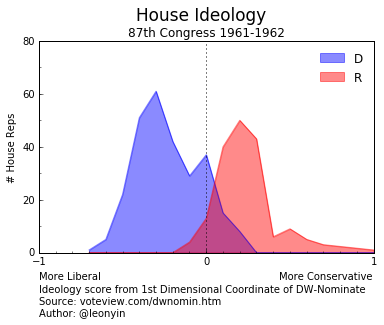

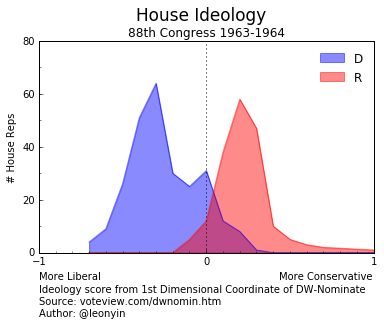

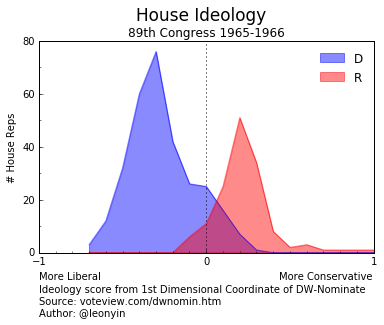

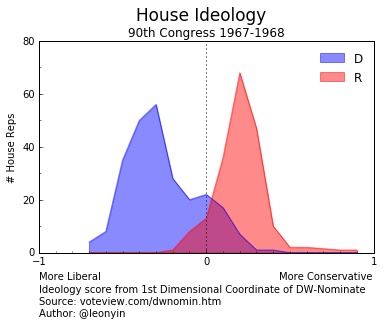

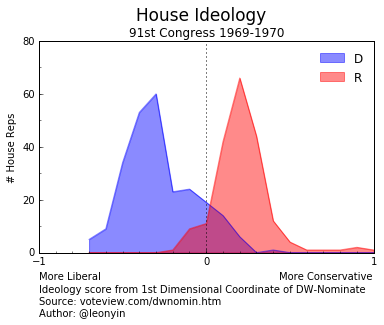

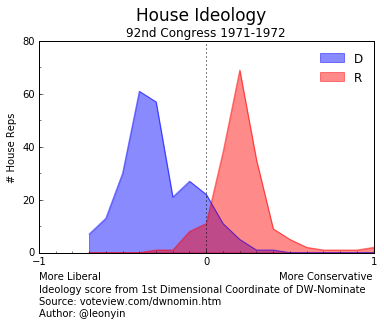

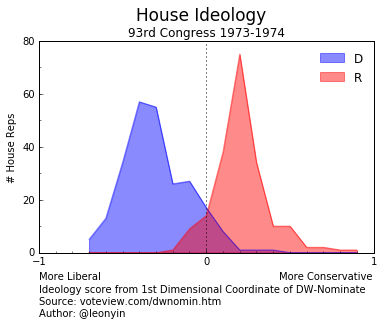

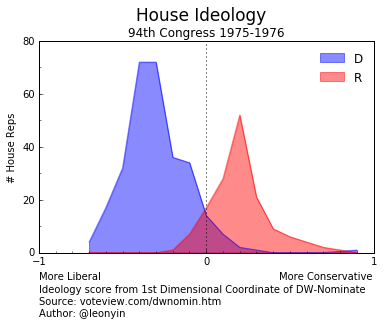

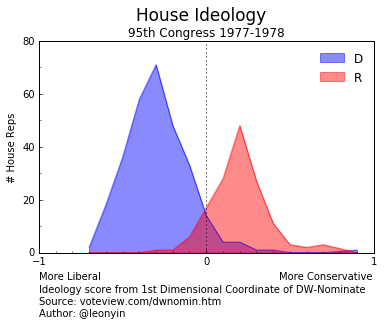

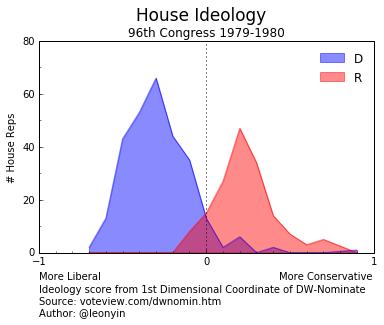

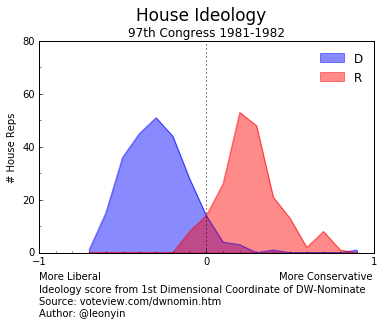

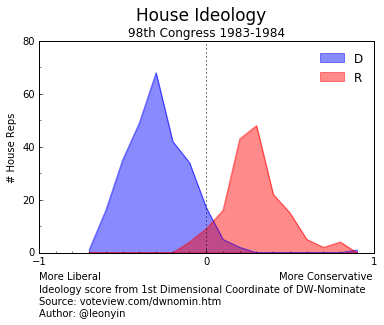

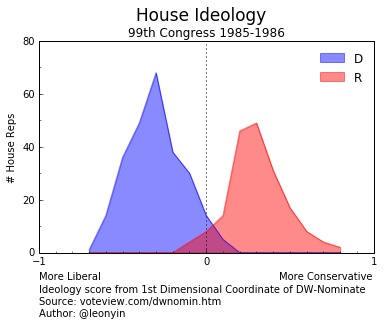

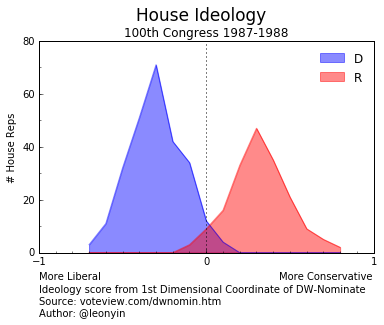

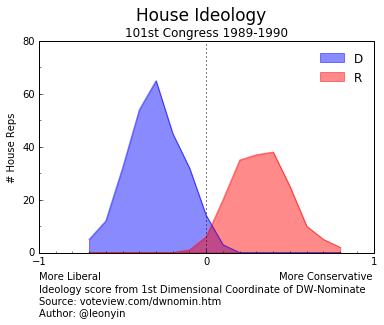

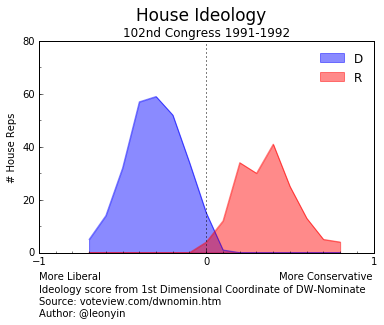

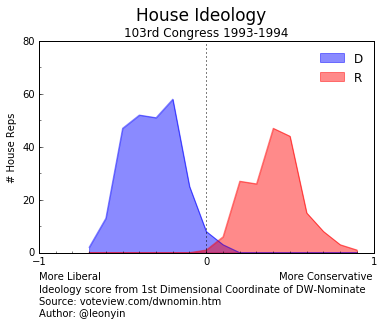

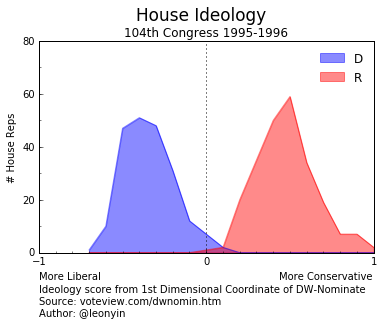

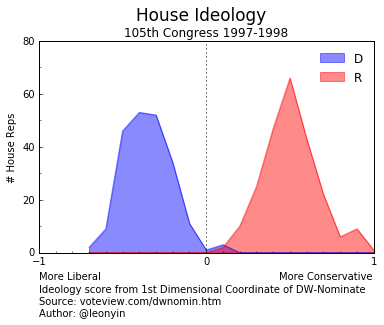

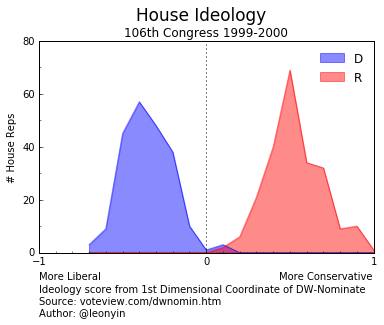

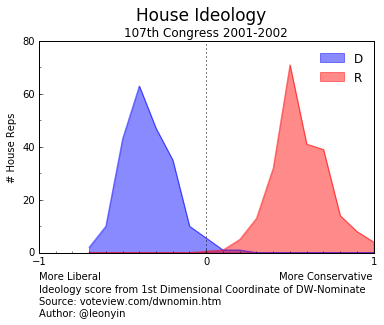

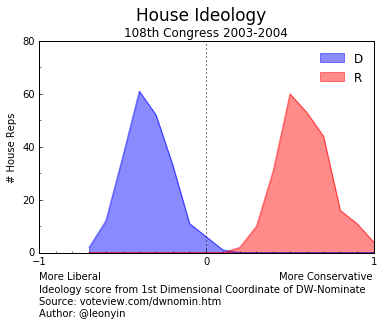

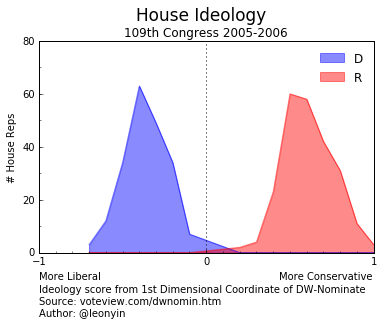

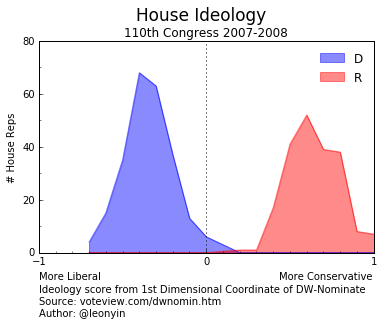

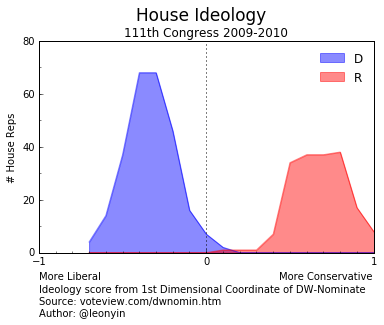

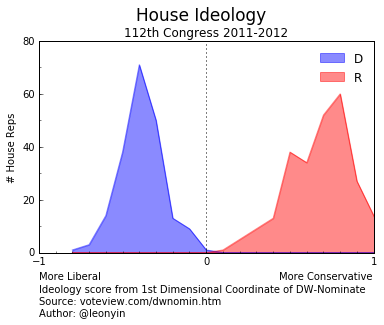

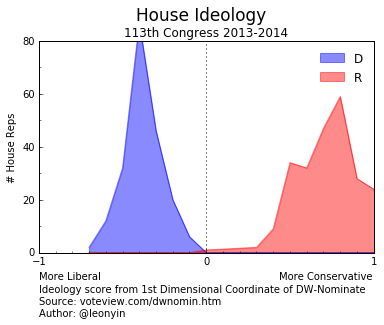

In [144]:
make_gif(congress='house',
         congress_start=87,
         congress_end=114)

In [147]:
import IPython

In [149]:
IPython.display.HTML('<iframe src="//giphy.com/embed/l3q2sdwiyf3bWCLwQ" '
                     'width="480" height="407" frameBorder="0" '
                     'class="giphy-embed" allowFullScreen></iframe>')

In [151]:
IPython.display.HTML('<iframe src="//giphy.com/embed/l3q2sdwiyf3bWCLwQ" '
                     'width="480" height="407" frameBorder="0" '
                     'class="giphy-embed" allowFullScreen></iframe>')

Notice that values on the liberal spectrum are almost never less than -0.7.<br>
Also notice the gradual polarization between the two parties.

This is the beginning of what we're going to use the Nominate dataset for.<br>
In the next notebook, we'll examine how we can extend the use of the Nominate dataset to the Propublica Congress API.